## Sélection des gènes fréquemment activés dans le cancer du foie et modèle de Cox:

### Importation des données:

In [1]:
# importations de quelques bibliothèques

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# genes spécifiques de tissus prédominants

specific_gene = pd.read_csv("gene_data.csv", sep='\t')
specific_gene = specific_gene['Gènes retenues'].values
print(specific_gene)
print(len(specific_gene))

['A4GNT' 'AADACL2' 'AANAT' ... 'ZSCAN23' 'ZSCAN5A' 'ZSWIM2']
3177


In [3]:
# Lecture du fichier Excel des données cliniques

data = pd.read_excel("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/Groups.xlsx")

**Nettoyage de données:**

In [4]:
# remplacer les NAN par des 0

data['NT'] = data['NT'].fillna(0)
data['All-tumours'] = data['All-tumours'].fillna(0)

In [5]:
# typage en entier

data['NT'] = data['NT'].astype(int)
data['All-tumours'] = data['All-tumours'].astype(int)

### dataset "TCGA-LIHC"

In [6]:
# données cliniques du dataset "TCGA-LIHC"

normal_data_TCGA_LIHC = data[(data['dataset'] == "TCGA-LIHC") & (data['NT'] == 1)]
tumoral_data_TCGA_LIHC = data[(data['dataset'] == "TCGA-LIHC") & (data['All-tumours'] == 1)]

In [7]:
# dataset "TCGA-LIHC"

expression_data_TCGA_LIHC = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_tcga_lihc_TCGA-LIHC_log_fpkm_439_samples_43022_genes.csv", sep=";")

# données d'expression concernant les gènes spécifiques
expression_data_TCGA_LIHC = expression_data_TCGA_LIHC[expression_data_TCGA_LIHC['gene_symbol'].isin(specific_gene)]
expression_data_TCGA_LIHC.head(3)

,id_gene,gene_symbol,TCGA-2V-A95S-01A,TCGA-2Y-A9GS-01A,TCGA-2Y-A9GT-01A,TCGA-2Y-A9GU-01A,TCGA-2Y-A9GV-01A,TCGA-2Y-A9GW-01A,TCGA-2Y-A9GX-01A,TCGA-2Y-A9GY-01A,...,TCGA-ZP-A9CZ-01A,TCGA-ZP-A9D0-01A,TCGA-ZP-A9D1-01A,TCGA-ZP-A9D2-01A,TCGA-ZP-A9D4-01A,TCGA-ZS-A9CD-01A,TCGA-ZS-A9CE-01A,TCGA-ZS-A9CF-01A,TCGA-ZS-A9CF-02A,TCGA-ZS-A9CG-01A
9,15,AANAT,0.092072,0.185105,0.016782,0.016354,0.057831,0.075875,0.014927,0.199500,...,0.044884,0.025738,0.000000,0.060324,0.038858,0.016782,0.000000,0.032524,0.088006,0.000000
34,41,ASIC1,0.092072,0.566474,0.037593,0.072037,0.022048,0.181166,0.164143,1.046421,...,0.146395,0.103531,0.088413,0.340391,0.273217,0.043484,0.015498,0.012354,0.071900,1.554392
38,49,ACR,0.000000,0.099632,0.258338,0.033934,0.192194,0.139469,0.046142,0.062536,...,0.046840,0.040261,0.106884,0.477885,0.523662,0.150040,0.094506,0.000000,0.311271,0.597412


### dataset "GSE121248"

In [8]:
# données cliniques du dataset "GSE121248"

normal_data_GSE121248 = data[(data['dataset'] == "GSE121248") & (data['NT'] == 1)]
tumoral_data_GSE121248 = data[(data['dataset'] == "GSE121248") & (data['All-tumours'] == 1)]

In [9]:
# données d'expression du dataset "GSE121248"

expression_data_GSE121248 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_GSE121248_GSE121248_log_expression_107_samples_21872_genes.csv", sep=";")

expression_data_GSE121248 = expression_data_GSE121248[expression_data_GSE121248['gene_symbol'].isin(specific_gene)]

### dataset "GSE76427"

In [10]:
# données cliniques du dataset "GSE76427"

normal_data_GSE76427 = data[(data['dataset'] == "GSE76427") & (data['NT'] == 1)]
tumoral_data_GSE76427 = data[(data['dataset'] == "GSE76427") & (data['All-tumours'] == 1)]

In [11]:
# données d'expression du dataset "GSE76427" 

expression_data_GSE76427 = pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_GSE76427_GSE76427_log_expression_167_samples_30499_genes.csv", sep=";")

expression_data_GSE76427 = expression_data_GSE76427[expression_data_GSE76427['gene_symbol'].isin(specific_gene)]

**Ci-après, nous allons créer une fonction qui permet de calculer les fréquences d'activations des gènes dans les différents datasets.**

In [12]:
# dans la préparation, mettre gene_symbol en index dans expression_data

def frequent_genes(expression_data, normal_data,tumoral_data):
    
    '''
    normal_data: données cliniques(EpiMed_experimental_grouping pour les échantillons normaux)
    
    tumoral_data: données cliniques(EpiMed_experimental_grouping pour les échantillons tumoraux)
    
    expression_data: données d'expressions de gènes
    
    '''

    # Préparation d'une liste pour les indices de colonnes correspondants
    selected_columns = [col for col in normal_data['id_sample'].unique() if col in expression_data.columns]

    # Sélection des données basées sur les colonnes correspondantes plus la colonne gene_symbol'
    normal_data_sample = expression_data[['gene_symbol'] + selected_columns]
    normal_data_sample=normal_data_sample.dropna(how='all', axis=1) # drop nan 
    
    # Mettre la colonne 'gene_symbol' comme index du DataFrame
    normal_data_sample = normal_data_sample.set_index('gene_symbol')

    # Préparation d'une liste pour les indices de colonnes correspondants
    selected_columns = [col for col in tumoral_data['id_sample'].unique() if col in expression_data.columns]

    # Sélection des données basées sur les colonnes correspondantes plus les colonnes 'id_gene' et 'gene_symbol'
    tumoral_data_sample = expression_data[['gene_symbol'] + selected_columns]
    tumoral_data_sample=tumoral_data_sample.dropna(how='all', axis=1) # drop nan 
    
    # Mettre la colonne 'gene_symbol' comme index du DataFrame
    tumoral_data_sample = tumoral_data_sample.set_index('gene_symbol')
    
    # Création d'un DataFrame vide avec les colonnes spécifiées pour les fréquences d'activaion NT
    frequence_norm = pd.DataFrame(columns=["gene_symbol", "seuil_normal", "freq_normal", "pourcentile_normal"])
    
    N1 = normal_data_sample.shape[1] # nombre de colonnes du tableau
    
    # Boucler sur chaque ligne de normal_data_sample
    for i in range(normal_data_sample.shape[0]):
        
        # le symbole du gène
        gene_symbol = normal_data_sample.index[i]
        
        # Calculer le seuil_normal comme la moyenne + 2*écart-type
        seuil_normal = normal_data_sample.iloc[i,:].mean() + 2 * normal_data_sample.iloc[i,:].std()
        
        # Calculer freq_normal comme le pourcentage de valeurs au-delà du seuil dans les colonnes
        freq_normal = np.sum(normal_data_sample.iloc[i, :] > seuil_normal) * 100 / N1
        
        # Calculer pourcentile_normal comme 100 - freq_normal
        pourcentile_normal = 100 - freq_normal
        
        # Ajouter ces valeurs au dataframe frequence
        new_line = pd.DataFrame([{ "gene_symbol": gene_symbol, 
                                      "seuil_normal": seuil_normal, 
                                      "freq_normal": freq_normal, 
                                      "pourcentile_normal": pourcentile_normal}])
        frequence_norm = pd.concat([frequence_norm, new_line], ignore_index=True)
        
    frequence_norm=frequence_norm.set_index('gene_symbol') # gene_symbol en index
    
    # Création d'un DataFrame vide avec les colonnes spécifiées pour les fréquences d'activation T(tumoral)
    frequence_tumo = pd.DataFrame(columns=["gene_symbol", "seuil_normal", "freq_tumoral", "pourcentile_tumoral"])
    
    N2 = tumoral_data_sample.shape[1] # nombre de colonnes du tableau
    
    # Boucler sur chaque ligne
    for i in range(tumoral_data_sample.shape[0]):
        
        # Extraire le symbole du gène
        gene_symbol = tumoral_data_sample.index[i]
        
        # Calculer le seuil_normal comme la moyenne + 2*écart-type 
        seuil_normal = normal_data_sample.iloc[i, :].mean() + 2 * normal_data_sample.iloc[i, :].std()
        
        # Calculer freq_normal comme le pourcentage de valeurs au-delà du seuil dans les colonnes
        freq_tumoral = np.sum(tumoral_data_sample.iloc[i, :] > seuil_normal) * 100 / N2
        
        # Calculer pourcentile_tumoral comme 100 - freq_tumoral
        pourcentile_tumoral = 100 - freq_tumoral
        
        # Ajouter ces valeurs au dataframe frequence
        new_line = pd.DataFrame([{"gene_symbol": gene_symbol, 
                                      "seuil_normal": seuil_normal, 
                                      "freq_tumoral": freq_tumoral, 
                                      "pourcentile_tumoral": pourcentile_tumoral}])
        frequence_tumo = pd.concat([frequence_tumo, new_line], ignore_index=True)
        
    frequence_tumo=frequence_tumo.set_index('gene_symbol') # gene_symbol en index
    
    # fréquences des gènes qui respectent les conditions(<5 pour NT et >10 pour T)
    list_data_tumo = frequence_tumo[frequence_tumo['freq_tumoral'] > 10]
    list_data_norm = frequence_norm[frequence_norm['freq_normal'] < 5]
    
    selected_genes=[gene for gene in list_data_norm.index.unique() if gene in list_data_tumo.index]
    gene_datas=pd.DataFrame(selected_genes, columns=['Gene_symbol'])
    
    return gene_datas
    

La fonction frequent_genes renvoie un DataFrame contenant la liste des gènes pour lesquels la fréquence d'activation est > 10% dans les chantillons de tumeur et < 5% dans les échantillons normaux. 

## Application de la fonction "frequent_genes"  sur les datasets:

**Pour le dataset TCGA-LIHC**

In [13]:
genes_data_TCGA_LIHC = frequent_genes(expression_data_TCGA_LIHC, normal_data_TCGA_LIHC, tumoral_data_TCGA_LIHC)

print(genes_data_TCGA_LIHC.shape)
genes_data_TCGA_LIHC.head()

(1282, 1)


,Gene_symbol
0,ASIC1
1,ACR
2,ACTC1
3,ACTN3
4,ADD2


**Pour le dataset GSE121248**

In [14]:
genes_data_GSE121248 = frequent_genes(expression_data_GSE121248, normal_data_GSE121248, tumoral_data_GSE121248)

print(genes_data_GSE121248.shape)
genes_data_GSE121248.head()

(489, 1)


,Gene_symbol
0,ASIC1
1,ACAN
2,ANXA13
3,AQP8
4,BMP8B


**Pour le dataset GSE76427**

In [15]:
genes_data_GSE76427 = frequent_genes(expression_data_GSE76427, normal_data_GSE76427, tumoral_data_GSE76427)

print(genes_data_GSE76427.shape)
genes_data_GSE76427.head()

(370, 1)


,Gene_symbol
0,ASIC1
1,AGRP
2,ANXA2P1
3,AQP8
4,AQP4


### Croisement(ou intersection) de nos trois résultats:

In [18]:
# Convertir les valeurs en ensembles pour des opérations d'intersection plus rapides

genes_data_GSE76427_vals = genes_data_GSE76427['Gene_symbol'].values
genes_data_GSE121248_vals = genes_data_GSE121248['Gene_symbol'].values
genes_data_TCGA_LIHC_vals = genes_data_TCGA_LIHC['Gene_symbol'].values

In [19]:
# Trouver l'intersection des trois ensembles
selected_genes=[gene for gene in genes_data_GSE76427_vals if (gene in genes_data_GSE121248_vals) & (gene in genes_data_TCGA_LIHC_vals)]
len(selected_genes)

109

In [20]:
selected_genes = pd.DataFrame(selected_genes)
selected_genes.head()

,0
0,ASIC1
1,AQP8
2,CYP27B1
3,SLC26A3
4,DSG1


In [20]:
selected_genes.to_csv('gene_symbol.csv', index=False, header=False, sep=';')

In [2]:
pip install matplotlib matplotlib-venn

In [21]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib.lines import Line2D

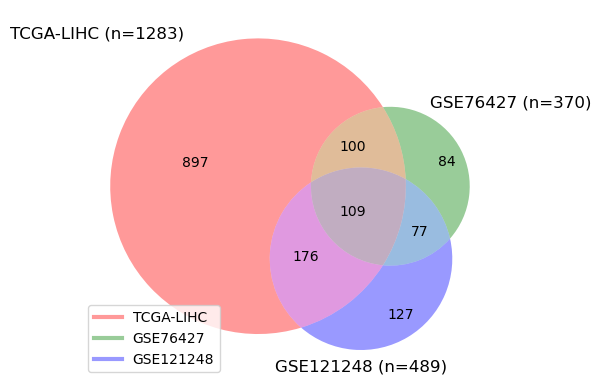

In [34]:
TCGA_LIHC = set(genes_data_TCGA_LIHC['Gene_symbol'].values)
GSE76427 = set(genes_data_GSE76427['Gene_symbol'].values)
GSE121248 = set(genes_data_GSE121248['Gene_symbol'].values) 

# Calculer les tailles des ensembles et des intersections
only_TCGA_LIHC = len(TCGA_LIHC - GSE76427 - GSE121248)
only_GSE76427 = len(GSE76427 - TCGA_LIHC - GSE121248)
only_GSE121248 = len(GSE121248 - TCGA_LIHC - GSE76427)

intersection_TCGA_LIHC_GSE76427 = len(TCGA_LIHC & GSE76427 - GSE121248)
intersection_TCGA_LIHC_GSE121248 = len(TCGA_LIHC & GSE121248 - GSE76427)
intersection_GSE76427_GSE121248 = len(GSE76427 & GSE121248 - TCGA_LIHC)

intersection_all_three = len(TCGA_LIHC & GSE76427 & GSE121248)

# Créer le diagramme de Venn
venn = venn3(subsets=(only_TCGA_LIHC, only_GSE76427, intersection_TCGA_LIHC_GSE76427,
                      only_GSE121248, intersection_TCGA_LIHC_GSE121248, intersection_GSE76427_GSE121248,
                      intersection_all_three), 
             set_labels=('TCGA-LIHC (n=1283)', 'GSE76427 (n=370)', 'GSE121248 (n=489)'))

# Ajouter des étiquettes personnalisées
venn.get_label_by_id('100').set_text(only_TCGA_LIHC)
venn.get_label_by_id('010').set_text(only_GSE76427)
venn.get_label_by_id('001').set_text(only_GSE121248)
venn.get_label_by_id('110').set_text(intersection_TCGA_LIHC_GSE76427)
venn.get_label_by_id('101').set_text(intersection_TCGA_LIHC_GSE121248)
venn.get_label_by_id('011').set_text(intersection_GSE76427_GSE121248)
venn.get_label_by_id('111').set_text(intersection_all_three)


# Extraire les couleurs utilisées dans le diagramme
colors = [patch.get_facecolor() for patch in venn.patches if patch is not None]

# Créer la légende avec les couleurs extraites
legend_elements = [Line2D([0], [0], color=colors[0], lw=3, label='TCGA-LIHC'),
                   Line2D([0], [0], color=colors[1], lw=3, label='GSE76427'),
                   Line2D([0], [0], color=colors[3], lw=3, label='GSE121248')]

plt.legend(handles=legend_elements, loc='lower left')

# Afficher le diagramme
plt.show()


## Modèle de Cox:

**Note: le modèle de Cox cherche notamment a étudié si l'augmentation du niveau d'expression de gènes impacte la survie.**

In [39]:
# les 109 gènes retenus dans l'étape de croisement entre les datasets pour les gènes fréquemment activés

genes_retenus = pd.read_csv("gene_symbol.csv", sep=';', header = None) 

In [40]:
# dataset "TCGA-LIHC"

expression_data_TCGA_LIHC=pd.read_csv("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/expression_data_tcga_lihc_TCGA-LIHC_log_fpkm_439_samples_43022_genes.csv", sep=";")

# on récupère les données dont les gènes sont présents dans les 109 gènes retenues
expression_data_TCGA_LIHC = expression_data_TCGA_LIHC[expression_data_TCGA_LIHC['gene_symbol'].isin(genes_retenus[0].values)]
print(expression_data_TCGA_LIHC.shape)
expression_data_TCGA_LIHC.head(3)

(109, 441)


,id_gene,gene_symbol,TCGA-2V-A95S-01A,TCGA-2Y-A9GS-01A,TCGA-2Y-A9GT-01A,TCGA-2Y-A9GU-01A,TCGA-2Y-A9GV-01A,TCGA-2Y-A9GW-01A,TCGA-2Y-A9GX-01A,TCGA-2Y-A9GY-01A,...,TCGA-ZP-A9CZ-01A,TCGA-ZP-A9D0-01A,TCGA-ZP-A9D1-01A,TCGA-ZP-A9D2-01A,TCGA-ZP-A9D4-01A,TCGA-ZS-A9CD-01A,TCGA-ZS-A9CE-01A,TCGA-ZS-A9CF-01A,TCGA-ZS-A9CF-02A,TCGA-ZS-A9CG-01A
34,41,ASIC1,0.092072,0.566474,0.037593,0.072037,0.022048,0.181166,0.164143,1.046421,...,0.146395,0.103531,0.088413,0.340391,0.273217,0.043484,0.015498,0.012354,0.071900,1.554392
270,343,AQP8,0.072037,0.064331,3.402886,1.303284,1.324868,2.172872,2.414623,0.114100,...,0.135272,2.184566,1.912037,0.037874,0.136323,1.777072,0.641176,2.615463,0.573956,1.063848
1241,1594,CYP27B1,0.582267,0.124196,0.726744,0.133695,0.215616,1.823219,0.218099,0.452701,...,0.151469,0.176578,0.142217,0.761711,0.131853,0.096127,0.338795,1.641962,1.703101,0.153027


In [41]:
# Lecture du fichier Excel EpiMed_experimental_grouping_2024.03.03_TCGA-LIHC

clinic_data_TCGA_LIHC = pd.read_excel("C:/Users/DIAGNE Ibrahima/Desktop/Stage_IAB_2024/data/EpiMed_experimental_grouping/EpiMed_experimental_grouping_2024.03.03_TCGA-LIHC.xlsx", sheet_name="standard exp_group")

# Affichage des dimensions pour vérification
print(clinic_data_TCGA_LIHC.shape)
clinic_data_TCGA_LIHC.head(3)

C:\Users\DIAGNE Ibrahima\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(439, 42)


,id_sample,main_gse_number,id_platform,organism,sample_title,sample_source,sex,ethnic_group,age_min,age_max,...,relapsed,dead,treatment,exposure,id_patient,tissue_group_level1,tissue_group_level2,tissue_group_level3,os_censor,dfs_censor
0,TCGA-G3-A3CG-01A,TCGA-LIHC,multi,Homo sapiens,d02deece-d8bc-4614-ac26-60a4282fdb07,Primary Tumor,M,not hispanic or latino,80.64,80.64,...,True,False,NaN,NaN,TCGA-G3-A3CG,liver,hepato_bilary,soma,0.0,1.0
1,TCGA-DD-AAVP-01A,TCGA-LIHC,multi,Homo sapiens,9259e9ee-7279-4b62-8512-509cb705029c,Primary Tumor,M,not hispanic or latino,48.86,48.86,...,True,False,NaN,NaN,TCGA-DD-AAVP,liver,hepato_bilary,soma,0.0,1.0
2,TCGA-FV-A3R3-01A,TCGA-LIHC,multi,Homo sapiens,8abda02f-aedf-4599-9407-e253207d5d4c,Primary Tumor,F,not hispanic or latino,38.99,38.99,...,False,True,NaN,NaN,TCGA-FV-A3R3,liver,hepato_bilary,soma,1.0,1.0


In [42]:
# suppression des NaN

clinic_data_TCGA_LIHC = clinic_data_TCGA_LIHC.dropna(subset=['os_months', 'os_censor'])

In [43]:
# Préparation d'une liste pour les indices de colonnes correspondants
selected_sample = [col for col in clinic_data_TCGA_LIHC['id_sample'].unique() if col in expression_data_TCGA_LIHC.columns]

# Sélection des données
expression_data_TCGA_LIHC = expression_data_TCGA_LIHC[['gene_symbol'] + selected_sample]

In [44]:
# Trouver les échantillons contenant des valeurs NaN dans expression_data_TCGA_LIHC
colonnes_avec_nan = expression_data_TCGA_LIHC.columns[expression_data_TCGA_LIHC.isna().any()].tolist()

print(colonnes_avec_nan)

['TCGA-BC-A10S-11A', 'TCGA-G3-A25W-01A', 'TCGA-G3-A25W-11A', 'TCGA-DD-A3A0-01A', 'TCGA-DD-A1EF-11A', 'TCGA-DD-AAE8-01A', 'TCGA-DD-A1ED-11A', 'TCGA-G3-A25X-11A', 'TCGA-DD-AADE-01A', 'TCGA-ES-A2HS-11A', 'TCGA-DD-A115-11A', 'TCGA-BC-A112-11A', 'TCGA-DD-AACM-01A', 'TCGA-DD-A1E9-11A', 'TCGA-DD-A1E9-01A']


In [45]:
# id_sample en index dans clinic_data_TCGA_LIHC

clinic_data_TCGA_LIHC = clinic_data_TCGA_LIHC.set_index('id_sample')     

In [46]:
# dans clinic_data_TCGA_LIHC, on suprrime les id_sample(ligne complète) qui ont des nan dans expression_data_TCGA_LIHC

clinic_data_TCGA_LIHC = clinic_data_TCGA_LIHC.drop(colonnes_avec_nan)

In [47]:
clinic_data_TCGA_LIHC.shape

(422, 41)

In [48]:
# suppression des échantillons qui ont des valeurs manquantes(NAN)

expression_data_TCGA_LIHC = expression_data_TCGA_LIHC.dropna(axis=1) 
expression_data_TCGA_LIHC.shape

(109, 423)

In [49]:
expression_data_TCGA_LIHC.head(3)

,gene_symbol,TCGA-G3-A3CG-01A,TCGA-DD-AAVP-01A,TCGA-FV-A3R3-01A,TCGA-G3-A25Y-01A,TCGA-DD-AADU-01A,TCGA-BC-A10S-01A,TCGA-5R-AA1D-01A,TCGA-G3-A25Z-01A,TCGA-DD-AAEH-01A,...,TCGA-DD-A39V-01A,TCGA-DD-A39V-11A,TCGA-DD-AAEK-01A,TCGA-DD-AAVX-01A,TCGA-DD-A11A-01A,TCGA-ZP-A9CY-01A,TCGA-BC-A10R-11A,TCGA-BC-A10R-01A,TCGA-QA-A7B7-01A,TCGA-CC-5264-01A
34,ASIC1,0.174279,3.806107,0.310805,0.730488,1.120949,0.029418,0.250598,0.019204,0.066537,...,1.615605,0.030124,0.888071,0.051720,0.021338,0.069702,0.027862,0.212134,0.035765,1.227864
270,AQP8,1.879078,5.055048,0.398460,0.062398,0.384271,1.625645,0.703721,2.199657,2.869082,...,0.254594,0.551688,0.624896,0.035905,2.449112,3.076371,2.216020,3.454847,0.142479,3.492110
1241,CYP27B1,0.138421,1.955350,0.057831,0.324350,0.246347,0.306846,0.205017,0.059771,0.032101,...,0.134615,0.052277,0.242694,0.145743,0.150040,0.282499,0.061984,0.088413,0.572502,0.785592


In [50]:
# gene_symbol en index dans expression_data_TCGA_LIHC 

expression_data_TCGA_LIHC = expression_data_TCGA_LIHC.set_index('gene_symbol') 

In [21]:
expression_data_TCGA_LIHC.to_csv('expression_data_TCGA_LIHC.csv',index=False, sep=';')

In [22]:
clinic_data_TCGA_LIHC.to_csv('clinic_data_TCGA_LIHC.csv',index=False, sep=';')

In [24]:
# installation de lifelines

pip install lifelines

     ------------------------------------ 349.2/349.2 kB 832.9 kB/s eta 0:00:00
     -------------------------------------- 49.3/49.3 kB 830.0 kB/s eta 0:00:00
     ---------------------------------------- 94.2/94.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4032 sha256=8eded07274adedc166822e5289a1427e45e97268c14eb92a2c05204434a68d74
  Stored in directory: c:\users\diagne ibrahima\appdata\local\pip\cache\wheels\a8\03\64\8557323821d25118c3a2dc1646996f7a962a8970d4b7d22473
Successfully built autograd-gamma
Note: you may need to restart the kernel to use updated packages.


In [51]:
# import some libraries

from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from statsmodels.stats.multitest import multipletests

In [52]:
clinic_data_TCGA_LIHC = clinic_data_TCGA_LIHC.reset_index()
expression_data_TCGA_LIHC = expression_data_TCGA_LIHC.reset_index()

In [53]:
# conversion en float
time = clinic_data_TCGA_LIHC['os_months'].astype(float)
censor = clinic_data_TCGA_LIHC['os_censor'].astype(float)

# données de survie
survival_data = pd.DataFrame({
    'duration': time,
    'event': censor
})

# Initialiser un dataframe pour les résultats de Cox
data_cox = pd.DataFrame(columns=["gene_symbol", "HR", "pval_cox"])

# Boucle sur chaque gène
for i in range(expression_data_TCGA_LIHC.shape[0]):
    gene_data = expression_data_TCGA_LIHC.iloc[i]
    
    # colonne du gène
    gene_name = gene_data['gene_symbol']
    df = pd.DataFrame(gene_data.drop(['gene_symbol']).values, columns=[gene_name])

    # Sélectionner uniquement la colonne du gène actuel pour le modèle de Cox
    X = pd.concat([survival_data, df], axis=1)
    X = X.dropna() # suppression des lignes de X contenant des NAN
    
    # modele de Cox
    cph = CoxPHFitter()
    cph.fit(X, duration_col='duration', event_col='event')
    summary = cph.summary

    # Récupérer la valeur p et le hazard ratio pour le gène actuel
    hr = summary.loc[gene_name, 'exp(coef)']  # Hazard ratio
    pval_cox = summary.loc[gene_name, 'p']  # p-value

    # Ajout des résultats au dataframe
    data_cox.loc[i] = [gene_name, hr, pval_cox]

# Afficher les résultats
data_cox.head()

,gene_symbol,HR,pval_cox
0,ASIC1,1.044088,0.713656
1,AQP8,0.963827,0.553223
2,CYP27B1,1.027711,0.884152
3,SLC26A3,1.192476,0.063730
4,DSG1,0.848517,0.071996


## Benjamini-Hochberg

Nous allons maintenant ajuster les p-valeurs de Cox avec la méthode de Benjamini-Hochberg

In [54]:
# pvals ajustés avec Benjamini-Hochberg
data = data_cox['pval_cox'].sort_values().reset_index()
pval_cox_adj = multipletests(data['pval_cox'], method='fdr_bh')[1]

data_cox = data_cox.loc[data['index']]
data_cox['pval_cox_adj'] = pval_cox_adj

In [55]:
data_cox.head()

,gene_symbol,HR,pval_cox,pval_cox_adj
59,ZFP69B,3.016599,0.000010,0.001067
108,SNHG4,1.688946,0.000054,0.002937
82,C5orf58,1.613373,0.000166,0.006023
53,ERCC6L,1.974202,0.000246,0.006058
37,POLR3G,2.214898,0.000278,0.006058


In [56]:
# filtrage 

data_filtre = data_cox[(data_cox['HR'] > 1.2) & (data_cox['pval_cox_adj'] < 0.1)]
print(f"length of data after filter : {len(data_filtre)}")
data_filtre.head()

length of data after filter : 27


,gene_symbol,HR,pval_cox,pval_cox_adj
59,ZFP69B,3.016599,0.000010,0.001067
108,SNHG4,1.688946,0.000054,0.002937
82,C5orf58,1.613373,0.000166,0.006023
53,ERCC6L,1.974202,0.000246,0.006058
37,POLR3G,2.214898,0.000278,0.006058


In [57]:
data_final = data_cox[(data_cox['HR'] > 1.2) & (data_cox['pval_cox'] < 0.05)]

In [58]:
len(data_final['gene_symbol']) 

30

In [59]:
# gènes obtenues par Katia

df2 = ['ATP6V1E2', 'B4GALNT1', 'C5orf58', 'CCDC121', 'CCDC138', 'CENPI', 'DEAF1', 'DSCC1', 'DUSP18', 'ENAM', 'ERCC6L', 
       'FAM133A', 'HOMER1', 'KIF4A', 'LIN28B', 'MYCN', 'OIP5', 'PIMREG', 'POLR3G', 'RGS5', 'RIBC2', 'RIMS3', 'RNASE2', 
       'ROR1', 'SCML2', 'SLC26A3', 'SLC39A10', 'SNHG4', 'SPATA24', 'SPC24', 'SPCS2P4', 'STXBP4', 'SWT1', 'TET1', 'TICRR', 
       'TNFSF4', 'ULBP2', 'USP13', 'ZFP69B', 'ZIC2', 'ZNF233', 'ZNF431']


In [44]:
data_final['gene_symbol'].values

array(['ZFP69B', 'SNHG4', 'C5orf58', 'ERCC6L', 'POLR3G', 'RIMS3', 'CENPI',
       'MYCN', 'SPCS2P4', 'SPESP1', 'SLC39A10', 'CTAG1A', 'ENAM',
       'HOMER1', 'RIBC2', 'DDX43', 'DUSP18', 'TICRR', 'KIF4A', 'GNGT1',
       'LIN28B', 'TET1', 'SOX2', 'CDKL3', 'DNAAF11', 'DSCC1', 'PABPC3',
       'SCML2', 'PIMREG', 'OIP5'], dtype=object)

data_final contient 30 gènes obtenus après avoir réalisé le modèle de Cox sur les 109 gènes fréquemment activés dans les tumeurs. Ces 30 gènes ont des p_valeurs < 0.05 et un hazard_ratio > 1.2  . 